In [14]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


In [3]:
#Calculate Weight for each parameter in the similarity index
def calculate_weight(ref_val, upper_lim, lower_lim, threshold=0.8):
  
  w_lower = math.log(threshold)/math.log(1-((ref_val - lower_lim)/(ref_val + lower_lim)))
  w_upper = math.log(threshold)/math.log(1-((upper_lim - ref_val)/(upper_lim + ref_val)))
  weight = round(math.sqrt(w_lower*w_upper), 2)
  return weight

In [4]:
#Calculate Earth Similarity Index for Individual Params

def calc_ESI_param(param, upper_lim, lower_lim,ref_val, threshold = 0.8):
  w = {'radius': 0.57, 'density': 1.07, 'escape_velocity': 0.70, 'revolution': 0.70, 'surface_gravity': 0.13, 'surface_temperature': 5.58}

  ref_values = {'radius': 1, 'density': 1, 'escape_velocity': 1, 'revolution': 1, 'surface_gravity': 1, 'surface_temperature': 288}
  # print(param.columns[0])
  # col_lower = param.columns[0].lower()
  # print(col_lower)
  if (param.columns[0] in ref_values):
    if pd.isna(ref_val):
        ref_val = ref_values[param.columns[0]]
    if pd.isna(upper_lim) or pd.isna(lower_lim):
        weight = w[param.columns[0]]
    else:
        weight = calculate_weight(ref_val, upper_lim,  lower_lim,  threshold)
  else:
    weight = calculate_weight(ref_val, upper_lim,  lower_lim,  threshold)  
    
  ESI_P = [] 
  
  for i in range(len(param)):
    V = round(math.pow(1-abs((param.iat[i,0] - ref_val)/(ref_val + param.iat[i,0])), weight), 6)
    ESI_P.append(V)
  
  return ESI_P
# return weight 

In [5]:
#Pass an array of Params to calculate 
#Pass an array of upper lims for respective Params 
#Pass an array of lower lims for respective Params

def calc_ESI(params, upper_lims=None, lower_lims=None,ref_val=None,int_param = None,surf_param = None):
    colnames = list(params.columns)
    
    #Default Upper Lims
    if upper_lims is None:
        upper_lims = [float("NaN")]*len(colnames)

    #Default Lower Lims 
    if lower_lims is None:
        lower_lims = [float("NaN")]*len(colnames)
   
    if ref_val is None:
        ref_val = [float("NaN")]*len(colnames)
        
    try:
        #Perform sanity checks 
        len(colnames) == len(upper_lims) == len(lower_lims) == len(ref_val)
        
        for i in range(0, len(upper_lims)):
            upper_lims[i]>=lower_lims[i]

        #Calculate Weights    
        ESI_df = pd.DataFrame()
        for i in range(0, len(colnames)):
            ESI_param = calc_ESI_param(params.iloc[:,[i]], upper_lims[i], lower_lims[i],ref_val[i])
            ESI_colname = "ESI_{}".format(colnames[i])
            ESI_df[ESI_colname] = ESI_param
        ESI_df.index = params.index
        if int_param != None:
            ESI_int_param = list('ESI_{}'.format(col) for col in int_param)
            ESI_df['ESI_Interior'] = SI_intsurf(ESI_df.loc[:,ESI_int_param])
        if surf_param != None:
            ESI_surf_param = list('ESI_{}'.format(col) for col in surf_param)
            ESI_df['ESI_Surface'] = SI_intsurf(ESI_df.loc[:,ESI_surf_param])
        if int_param != None and surf_param != None:
            ESI_df['ESI_Global'] = SI_intsurf(ESI_df.loc[:,['ESI_Interior','ESI_Surface']])
        return ESI_df
        
        
    
    except ValueError as e:
        print(e)

    


In [6]:
#function to calculate combined ESI
def SI_intsurf(data):
    SI_intsurf_df = pd.DataFrame()
    n = len(data.columns)
    data.loc[:,'new'] = 1
    for i in range(0,n):
        data.loc[:,'new'] = data.loc[:,'new']*data.iloc[:,i]
    
    data.loc[:,'new'] = pow(data.loc[:,'new'],1/n)
    return data.loc[:,'new']
    


In [40]:
params = ['radius', 'density']
df = pd.read_csv(r"C:\Users\raiad\Downloads\Rock NESI.csv") 
upper_lims=[1.9, 1.5,1.4,323]
lower_lims = [0.5, 0.7,0.4,273]
ref_val = [1,1,1,288]
#surf_param=['P. Esc Vel (EU)','P. Teq Mean (K)']
#int_param=['P. Radius (EU)','P. Density (EU)']
ESI_data2 = calc_ESI(df.iloc[:,[5,6,8,9]],upper_lims,lower_lims,ref_val,surf_param=['P. Esc Vel (EU)','P. Teq Mean (K)'],int_param=['P. Radius (EU)','P. Density (EU)'])
ESI_data2 

,ESI_P. Radius (EU),ESI_P. Density (EU),ESI_P. Esc Vel (EU),ESI_P. Teq Mean (K),ESI_Interior,ESI_Surface,ESI_Global
0,0.795160,0.968867,0.744237,0.000797,0.877727,0.024355,0.146208
1,0.849972,0.949134,0.800181,0.008904,0.898186,0.084409,0.275344
2,0.975223,0.937854,0.989632,0.008420,0.956356,0.091284,0.295465
3,0.760925,0.797841,0.648872,0.175358,0.779164,0.337320,0.512667
4,0.807548,0.890053,0.732509,0.005459,0.847797,0.063236,0.231541
...,...,...,...,...,...,...,...
1562,0.957080,0.955483,0.963215,0.151602,0.956281,0.382133,0.604505
1563,0.822139,0.790986,0.718071,0.000522,0.806412,0.019361,0.124950
1564,0.962169,0.949666,0.969658,0.597457,0.955897,0.761137,0.852976
1565,0.862991,0.963860,0.823376,0.465422,0.912032,0.619045,0.751392


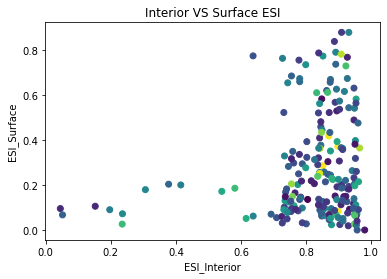

In [41]:
#PLOTTING FUNCTIONS
#1.Plot Interior vs Surface ESI
def plot1(df):  
    sample = random.sample(sorted(df['ESI_Global']),200)
    data_x = df['ESI_Interior'].head(200)
    data_y = df['ESI_Surface'].head(200)
    
    fig,ax = plt.subplots(1)
    scatter = ax.scatter(data_x, data_y, cmap="viridis", c=sample)
    plt.xlabel("ESI_Interior")
    plt.ylabel("ESI_Surface")
    plt.title("Interior VS Surface ESI")
    
    #Create Annotation Object
    annotation = ax.annotate(
        text='',
        xy=(0, 0),
        xytext=(15, 15), # distance from x, y
        textcoords='offset points',
        bbox={'boxstyle': 'round', 'fc': 'w'},
        arrowprops={'arrowstyle': '->'}
    )
    annotation.set_visible(False)


    def mouse_hover(event):
        annotation_visbility = annotation.get_visible()
        if event.inaxes == ax:
            is_contained, annotation_index = scatter.contains(event)

            if is_contained:
                data_point_location = scatter.get_offsets()[annotation_index['ind'][0]]
                
                annotation.xy = data_point_location
                print(data_point_location)

                xlabel = round(data_point_location[0],2)
                ylabel = round(data_point_location[1],2)
                text_label = f"{xlabel},{ylabel}"
                #text_label = '({0:.2f}, {0:.2f})'.format(data_point_location[0], data_point_location[1])
                annotation.set_text(text_label)
                annotation.set_visible(True)
                fig.canvas.draw_idle()
                
            else:
                if annotation_visbility:
                    annotation.set_visible(False)
                    fig.canvas.draw_idle()


    fig.canvas.mpl_connect('motion_notify_event', mouse_hover)
    plt.show()

plot1(ESI_data2)

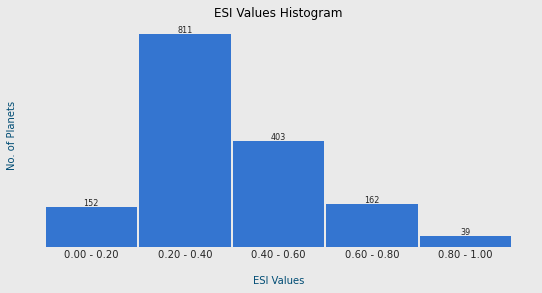

In [95]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

#Plot 2: Planetary bodies histogram
def plot2(df):

    facecolor = '#EAEAEA'
    color_bars = '#3475D0'
    txt_color1 = '#252525'
    txt_color2 = '#004C74'

    # df['bin'] = pd.cut(df['ESI_Global'], [0,0.2,0.4,0.6,0.8,1.0], labels=['0-0.2','0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'])
    # imd = df.groupby(['bin']).count()
    # y = imd['ESI_Global']
 
    # plot
    fig, ax = plt.subplots(facecolor=facecolor, figsize=(8,4))
    ax.set_facecolor(facecolor)
    n, bins, patches = ax.hist(df['ESI_Global'], bins=[0,0.2,0.4,0.6,0.8,1.0], color=color_bars)


    minor_locator = AutoMinorLocator(2)
    plt.gca().xaxis.set_minor_locator(minor_locator)
    plt.grid(which='minor', lw = 2.0, color=facecolor)

    # x ticks labels
    x_tickslabels = [ "{:.2f} - {:.2f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
    # x ticks positions
    x_ticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]

    plt.xticks(x_ticks, labels = x_tickslabels, c=txt_color1, fontsize=10)
    


    plt.xlabel('\nESI Values', c=txt_color2, fontsize=10)
    plt.ylabel('No. of Planets', c=txt_color2, fontsize=10)
    plt.tight_layout()
    plt.title('ESI Values Histogram', loc = 'center', fontsize = 12)
   
    # remove major and minor ticks from the x axis, but keep the labels
    ax.tick_params(axis='x', which='both',length=0)
    # Hide the right and top spines
    # remove major and minor ticks from the x axis, but keep the labels
    ax.tick_params(axis='x', which='both',length=0)
    
    # remove y ticks
    plt.yticks([])


    # Hide the right and top spines
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plot values on top of bars
    for idx, value in enumerate(n):
        if value > 0:
            plt.text(x_ticks[idx], value+5, int(value),ha='center', fontsize=8, c=txt_color1)
            
                
plot2(ESI_data2)

In [376]:
### MAKE USER ENTER CSV WITH VARIOUS COLUMNS CALCULATE ESI FOR EACH ENTRY 

#1. Read Column Names 
#2. Browse column names and select columns which are in the ESI Formula - Data Cleaning features we need to add 
#3. Give option to add custom parameters - FUTURE WORK 
#4. Calculate weights for each parameters 
#5. How to take upper lims and lower lims - FUTURE WORK 
#6. Calculate ESI 


In [377]:
def readData(csv):

    #1. Read Column Names 
    df = pd.read_csv(csv) 
    cols = list(df.columns)
    print(cols)
    cols_lower = [col.lower() for col in cols]
    print(cols_lower)

    #2. Browse column names and select columns which are in the ESI Formula
    columns = ['radius', 'density', 'escape_velocity', 'revolution']
    
    common_cols = []

    for i in range(0, len(columns)):     
        for j in range(0, len(cols_lower)):
            if columns[i] in cols_lower[j]:
                df.rename({cols[j]: columns[i]}, inplace=True, axis=1)
                common_cols.append(columns[i])

   
    new_df = df[common_cols].copy()   

    return new_df      




new_df = readData(r"D:/Downloads/Rock NESI.csv")

['P. Name', 'P. Name Kepler', 'P. Name KOI', 'P. Composition Class', 'P. Mass (EU)', 'P. Radius (EU)', 'P. Density (EU)', 'P. Gravity (EU)', 'P. Esc Vel (EU)', 'P. Teq Mean (K)', 'P. Ts Mean (K)', 'P. Surf Press (EU)', 'P. Period (days)', 'P. Mean Distance (AU)', 'Distance (Km)', 'S. Mass (SU)', 'S.Mass (Kg)', 'Rev (Days)', 'Rev (EU)', 'ESI(R)', 'ESI(D)', 'ESI (Ve)', 'ESI(T)', 'ESI(Rev)', 'ESI(g)', 'ESI_I', 'ESI_S', 'ESI']
['p. name', 'p. name kepler', 'p. name koi', 'p. composition class', 'p. mass (eu)', 'p. radius (eu)', 'p. density (eu)', 'p. gravity (eu)', 'p. esc vel (eu)', 'p. teq mean (k)', 'p. ts mean (k)', 'p. surf press (eu)', 'p. period (days)', 'p. mean distance (au)', 'distance (km)', 's. mass (su)', 's.mass (kg)', 'rev (days)', 'rev (eu)', 'esi(r)', 'esi(d)', 'esi (ve)', 'esi(t)', 'esi(rev)', 'esi(g)', 'esi_i', 'esi_s', 'esi']


In [378]:
#4. Calculate weights for each parameters based on default limits
new_cols = list(new_df.columns)
print (new_df)
#OPTIONAL - Pass upper and lower lims or will take default values 
#calc_ESI(new_cols,upper_lims, lower_lims)

      radius  density
0       1.99     1.06
1       1.66     1.10
2       1.09     0.89
3       2.23     1.47
4       1.91     1.23
...      ...      ...
1562    1.16     0.92
1563    1.82     1.49
1564    1.14     0.91
1565    1.59     1.07
1566    1.68     1.11

[1567 rows x 2 columns]


In [379]:
data = [['mercury',0.38,0.98],['mars',0.53,0.71]]
data = pd.DataFrame(data,columns=['p name','radius', 'density'])
print(data.iloc[:,[1,2]])

   radius  density
0    0.38     0.98
1    0.53     0.71


In [380]:
#function to convert units of P1 wrt P2, all columns should have same units
def unit_conv(data,ref_index):
    unit_conv_df = pd.DataFrame()   
    for j in data.index:
        k=0 
        for i in data.columns:
            x = float(data.loc[j,i])/ref_index[k]
            unit_conv_df.loc[j,i] = x
            k+=1
    return unit_conv_df

In [382]:
mars_data = unit_conv(df.iloc[:,[5,6,8]],[0.53,0.71,0.45])
mars_data


,P. Radius (EU),P. Density (EU),P. Esc Vel (EU)
0,3.754717,1.492958,4.555556
1,3.132075,1.549296,3.888889
2,2.056604,1.253521,2.288889
3,4.207547,2.070423,6.022222
4,3.603774,1.732394,4.711111
...,...,...,...
1562,2.188679,1.295775,2.466667
1563,3.433962,2.098592,4.911111
1564,2.150943,1.281690,2.422222
1565,3.000000,1.507042,3.644444
